# Import the necessary libraries

In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
import tensorflow as tf
from tensorflow import keras
import albumentations as A
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D
from keras.models import Sequential

from ipywidgets import widgets, interact

import warnings
warnings.filterwarnings("ignore")

# Reading the data

In [2]:
# Reading the direction for the images
tumor_dir = "D:/Mzakra/Semester 5/Data Science Tools/Brain Tumor Data Set/Brain Tumor" 
healthy_dir = "D:/Mzakra/Semester 5/Data Science Tools/Brain Tumor Data Set/Healthy"

# Reading the csv file that contain the data about the images
df = pd.read_csv("D:/Mzakra/Semester 5/Data Science Tools/Brain Tumor Data Set/metadata.csv")
df = df.drop(df.columns[0], axis=1)
df.head()

,image,class,format,mode,shape
0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [7]:
# Showing the main charactaristics of each column in the dataset
@interact(column = df.columns)
def column_info(column):
    print("*" * 10, column, "*" * 10)
    display(df[column].value_counts())
    print("-" * 30)
    display(df[column].describe())
    print("=" * 40)

interactive(children=(Dropdown(description='column', options=('image', 'class', 'format', 'mode', 'shape'), va…

# Getting the images into tumor & healthy lists

In [3]:
tumor = []
healthy = []

for i in range(len(df)):
    img = df.iloc[i,0]
    if df.iloc[i,1] == 'tumor':
        tumor.append(os.path.join(tumor_dir, img))
    else:
        healthy.append(os.path.join(healthy_dir, img))

# Split the data to train & test 

In [4]:
random.shuffle(tumor)
random.shuffle(healthy)

# Split the data 80:20
tumor_train = tumor[:int(len(tumor)*0.8)]
tumor_test = tumor[int(len(tumor)*0.8):]

healthy_train = healthy[:int (len (healthy) *0.8)]
healthy_test = healthy[int (len (healthy) *0.8):]

print ('Train Data  = {}'.format(len(tumor_train)+len(healthy_train)))
print ('# of train_tumor  = {}'.format(len(tumor_train)))
print ('# of train_healthy = {}'.format(len(healthy_train)))

print ('===========================')

print ('Test Data  = {}'.format(len(tumor_test)+len(healthy_test)))
print ('# of test_tumor = {}'.format(len (tumor_test)))
print ('# of test_healthy = {}'.format(len (healthy_test)))

Train Data  = 3679
# of train_tumor  = 2010
# of train_healthy = 1669
Test Data  = 921
# of test_tumor = 503
# of test_healthy = 418


# Show some samples

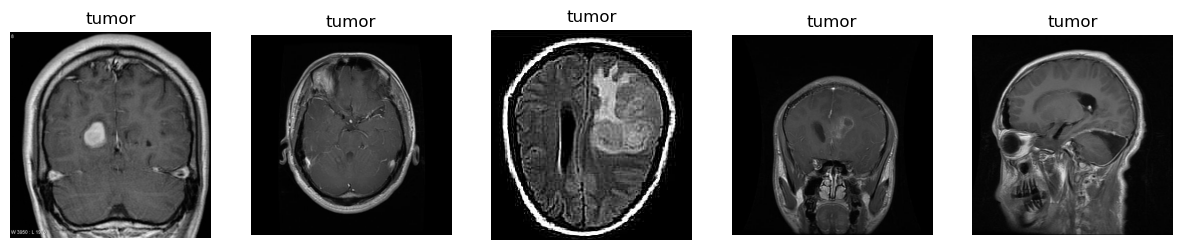

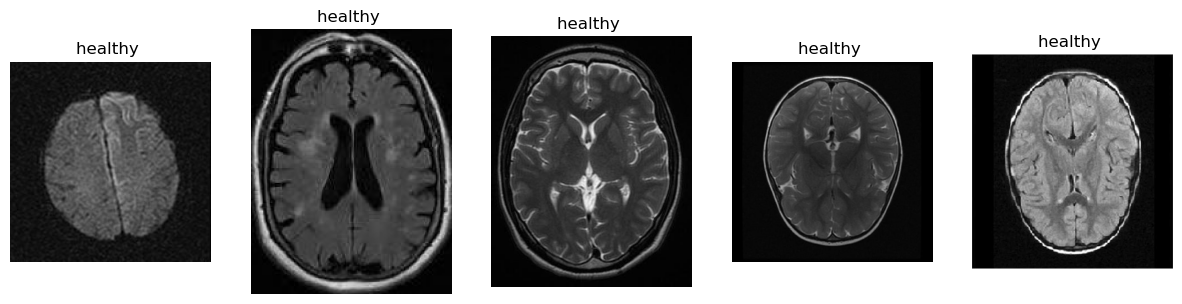

In [5]:
def plot_images(data , image_title, num_of_images):
    plt.figure(figsize=(15,10))
    for i in range(num_of_images):
        random_image = random.choice(data)
        if type (data) == list:
            random_image = cv2.imread(random_image)

            if len (random_image.shape) == 3:
                random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
            if len (random_image.shape) == 2:
                random_image = cv2.cvtColor(random_image, cv2.COLOR_GRAY2RGB)
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(random_image)
        plt.axis('off')
        plt.title(image_title)
    
    plt.show()

plot_images(tumor_train ,'tumor',5)
plot_images(healthy_train ,'healthy ',5)

## The % differance between the 2 classes

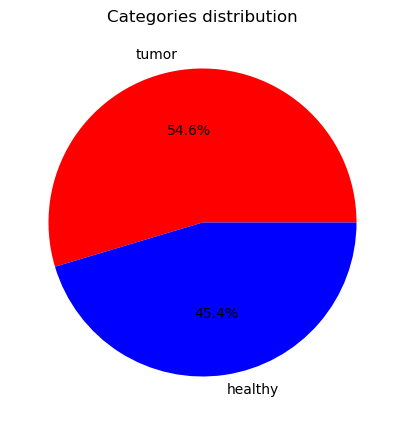

In [6]:
def make_pie(data,labels,colors,title):
    plt.figure(figsize=(16,5))
    plt.pie(data,labels = labels, colors = colors, autopct='%1.1f%%')
    plt.title(title)
    plt.show()
    
data = [len(tumor_train),len(healthy_train)]
labels = ['tumor','healthy']
colors = ['red','blue']
make_pie(data,labels,colors,'Categories distribution')

# Image Augmentation & Preprocessing for Train data

In [7]:
def image_augmentation(data, target, p=0.5):
    
    images =[]
    albumentations_list = [A.RandomBrightness(limit = 0.5, p=p), A.RGBShift(p=p), A.RandomContrast(limit = 0.5,p=p),
                          A.Rotate(p=p, limit=40), A.RandomCrop(p=p,height = 200, width = 200)]
    
    while(len(images) < target):
        for image in data:
            # resize the images to 256 * 256
            img = cv2.resize(cv2.imread(image), (256, 256))
            # convert the images to RGBscale
            if len (img.shape) == 3:
                random_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            # Choice a random augmentation from the list and apply it
            operation = random.choice(albumentations_list)
            img = operation(image = img)['image']
            if img.shape[0] !=256:
                img = cv2.resize(img, (256, 256))
    
            images.append(img)
            #Try to remove it
            if (len(images) >= target):
                break
    return np.array(images)

In [8]:
tumor_train_aug = image_augmentation(tumor_train,5000)
healthy_train_aug = image_augmentation(healthy_train,5000)

## Number of train images after augmentation 

In [9]:
print ('Train Data = {}'.format(len(tumor_train_aug)+len(healthy_train_aug)))
print ('# of train_tumor_aug = {}'.format(len(tumor_train_aug)))
print ('# of train_healthy_aug = {}'.format(len(healthy_train_aug)))

Train Data = 10000
# of train_tumor_aug = 5000
# of train_healthy_aug = 5000


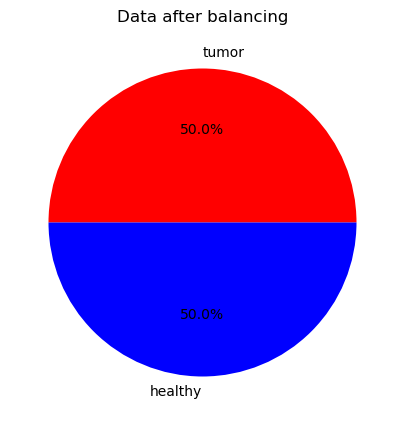

In [10]:
make_pie([len(tumor_train_aug), len(healthy_train_aug)] ,labels,colors,'Data after balancing')

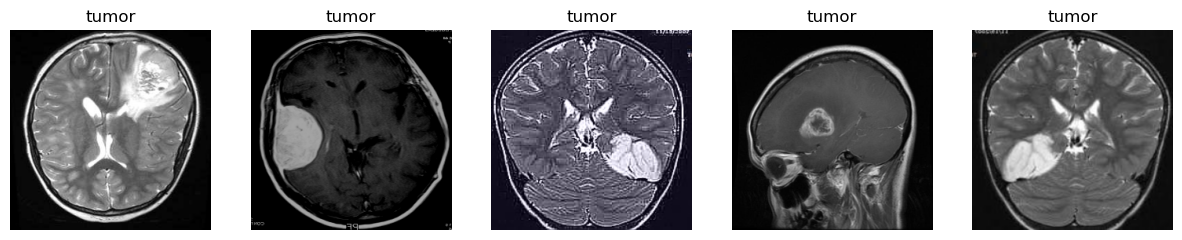

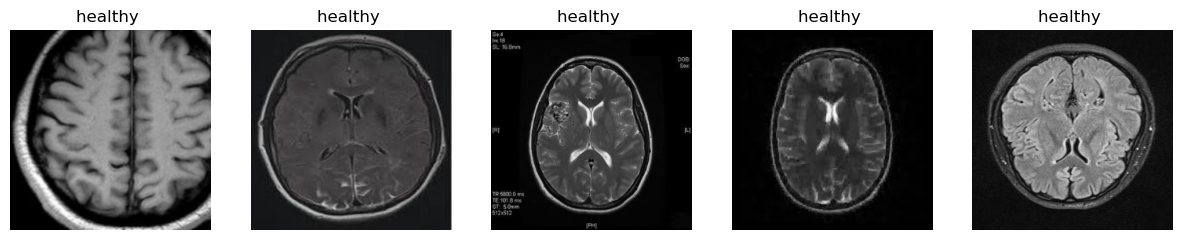

In [11]:
# Show some images after augmentations
plot_images(tumor_train_aug , 'tumor', 5)
plot_images(healthy_train_aug , 'healthy ', 5)

# Now lets do simple preprocessing for the test data

In [12]:
def preprocess_test_data(data):
    images = []
    for image in data:
        img = cv2.resize(cv2.imread(image),(256, 256))
        if len (img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img)
    return np.array(images)

In [13]:
tumor_test = preprocess_test_data(tumor_test)
healthy_test = preprocess_test_data(healthy_test)

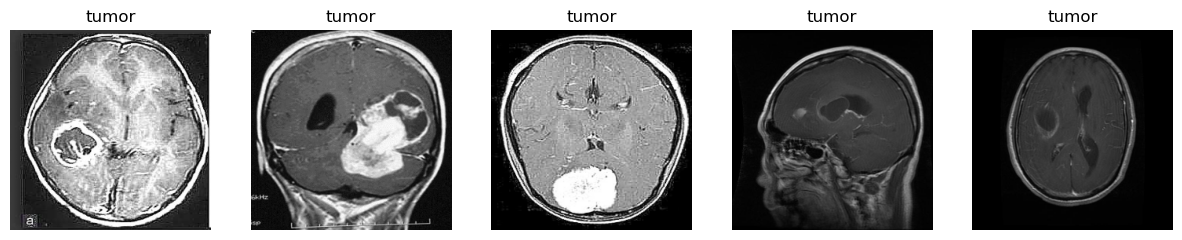

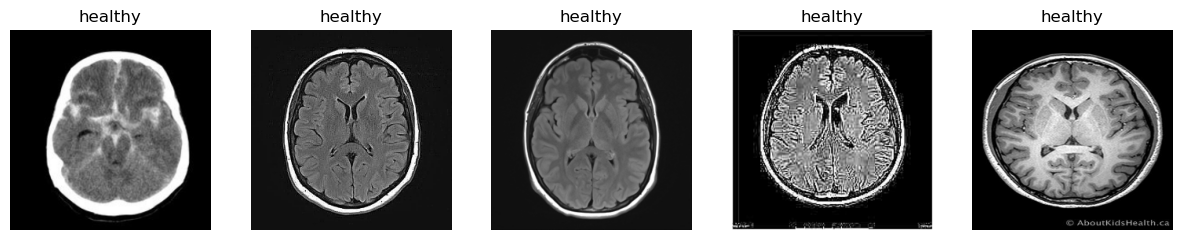

In [14]:
# Show some images after preprocessing
plot_images(tumor_test,'tumor', 5)
plot_images(healthy_test,'healthy', 5)

# Concat the training and test data

In [15]:
X_train = np.concatenate([tumor_train_aug,healthy_train_aug],axis = 0)
X_test = np.concatenate([tumor_test,healthy_test],axis = 0)

# {0 => tumor & 1 => healthy}
y_train = np.concatenate([np.zeros(len(tumor_train_aug)), np.ones(len(healthy_train_aug))])
y_test = np.concatenate([np.zeros(len(tumor_test)), np.ones(len(healthy_test))])

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(10000, 256, 256, 3)
(10000,)
(921, 256, 256, 3)
(921,)


# Rescale the images

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=16, shuffle=True)
test_generator = test_datagen.flow(X_test, y_test, batch_size=16, shuffle=True)

# Making the model

In [17]:
model = Sequential()

model.add(InputLayer(input_shape=(256,256,3)))

model.add(Conv2D(16, (3*3), activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(32, (3*3), activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(16, (3*3), activation="relu"))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [18]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.5e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(train_generator,epochs=5,validation_data=test_generator)

Epoch 1/5
625/625 [==============================] - 701s 1s/step - loss: 0.4270 - accuracy: 0.7962 - val_loss: 0.2225 - val_accuracy: 0.9186
Epoch 2/5
625/625 [==============================] - 697s 1s/step - loss: 0.2061 - accuracy: 0.9160 - val_loss: 0.1068 - val_accuracy: 0.9620
Epoch 3/5
625/625 [==============================] - 704s 1s/step - loss: 0.1089 - accuracy: 0.9586 - val_loss: 0.1210 - val_accuracy: 0.9609
Epoch 4/5
625/625 [==============================] - 697s 1s/step - loss: 0.0536 - accuracy: 0.9800 - val_loss: 0.0902 - val_accuracy: 0.9729
Epoch 5/5
625/625 [==============================] - 698s 1s/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0915 - val_accuracy: 0.9739


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      3904      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 116, 32)      41504     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 16)        41488     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 16)       0

# Plot the Accuracy history

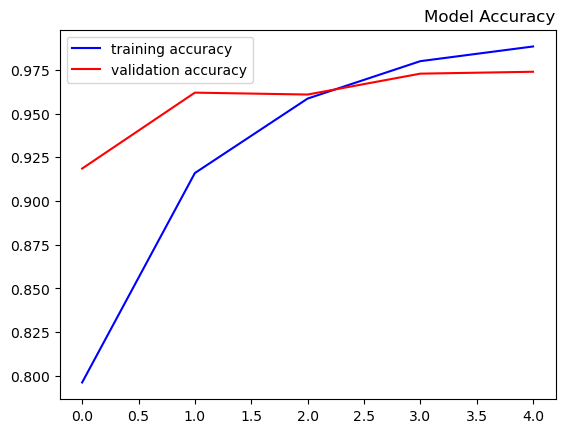

In [21]:
tarin_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(tarin_acc, c = 'b', label = 'training accuracy')
plt.plot(val_acc, c = 'r', label = 'validation accuracy')
plt.title('Model Accuracy', loc ='right')
plt.legend()
plt.show()

# Plot the Loss history

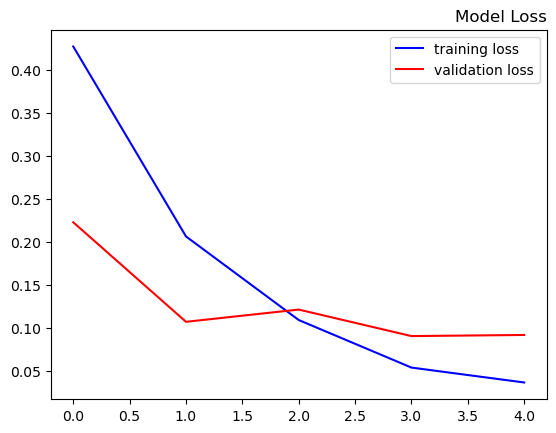

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, c = 'b', label = 'training loss')
plt.plot(val_loss, c = 'r', label = 'validation loss')
plt.title('Model Loss', loc ='right')
plt.legend()
plt.show()

# Test the model

1/1 [==============================] - 0s 41ms/step
The predicted class is Healthy Brain


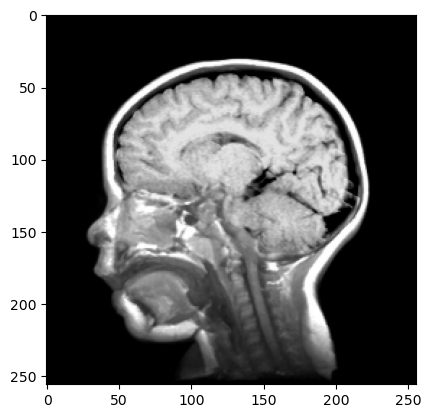

In [32]:
img = cv2.imread("D:/Mzakra/Semester 5/Data Science Tools/Brain Tumor Data Set/healthy_test.jpg")
resized = tf.image.resize(img, (256,256))
plt.imshow(resized.numpy().astype(int))

yhat = model.predict(np.expand_dims(resized/255, 0))
if yhat > 0.5:
    print("The predicted class is Healthy Brain")
else:
    print("The predicted class is Tumor Brain")

1/1 [==============================] - 0s 38ms/step
The predicted class is Tumor Brain


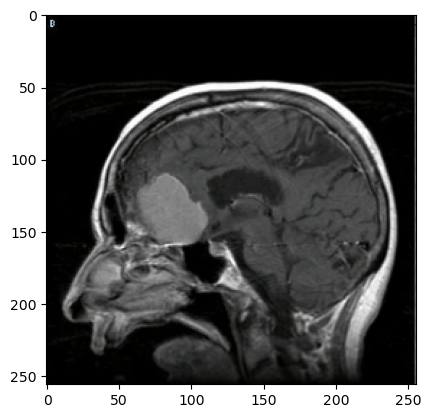

In [33]:
img = cv2.imread("D:/Mzakra/Semester 5/Data Science Tools/Brain Tumor Data Set/tumor_test.jpg")
resized = tf.image.resize(img, (256,256))
plt.imshow(resized.numpy().astype(int))

yhat = model.predict(np.expand_dims(resized/255, 0))
if yhat > 0.5:
    print("The predicted class is Healthy Brain")
else:
    print("The predicted class is Tumor Brain")